In [1]:
import pandas as pd
import numpy as np
import os
from acquire import get_hwyrail, get_equiprail
from prepare import prep_hwy_df, prep_equip_df
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from scipy import stats
from sklearn.model_selection import train_test_split

from datetime import date, datetime
from explore import train_validate_test_split, freq_table

In [2]:
df = get_hwyrail()

In [3]:
df.shape

(18995, 104)

In [4]:
df = prep_hwy_df(df)

In [5]:
df.shape

(12181, 50)

In [6]:

df.railroad_company.value_counts()



UP      2959
CSX     2825
NS      2715
BNSF    2274
ATK      956
KCS      452
Name: railroad_company, dtype: int64

In [7]:
df.season.value_counts()

Fall      3176
Winter    3116
Summer    3093
Spring    2796
Name: season, dtype: int64

In [8]:
df['year'] = df['date'].dt.year

In [9]:
df.state.value_counts()

 TX    1631
 GA     751
 IN     727
 CA     698
 AL     583
 IL     518
 OH     516
 LA     492
 SC     361
 NC     359
 KY     355
 PA     352
 FL     344
 MO     343
 TN     342
 AR     307
 OK     293
 KS     277
 VA     275
 NE     274
 MS     216
 WA     199
 MN     182
 CO     165
 MI     157
 AZ     152
 WV     150
 IA     138
 MD     121
 NY     119
 ND     113
 ID     108
 WI      89
 OR      79
 NM      72
 MT      62
 SD      54
 NJ      51
 UT      38
 WY      37
 DE      29
 MA      16
 NV      15
 VT       8
 CT       5
 ME       4
 NH       2
 DC       2
Name: state, dtype: int64

## Takeaway

 - states like Texas, Georgia, Indiana, Alabama, Ohio rank highest in hwy rail accidents while states in the NE like Vermont, Conneticut & DC are at the very bottom.
     - is this because people in NE are more accustomed to trains and people in middle america don't see them as often?
     - Need to look at state populations and compare average accident (i.e., vermont could have 5 people but 2 accidents while Texas could have 28 million people and 1,000 accidents. need to look at the numbers and compare

Initial hypothesis

 - Rail accidents are more prevelant in southern and middle america
     

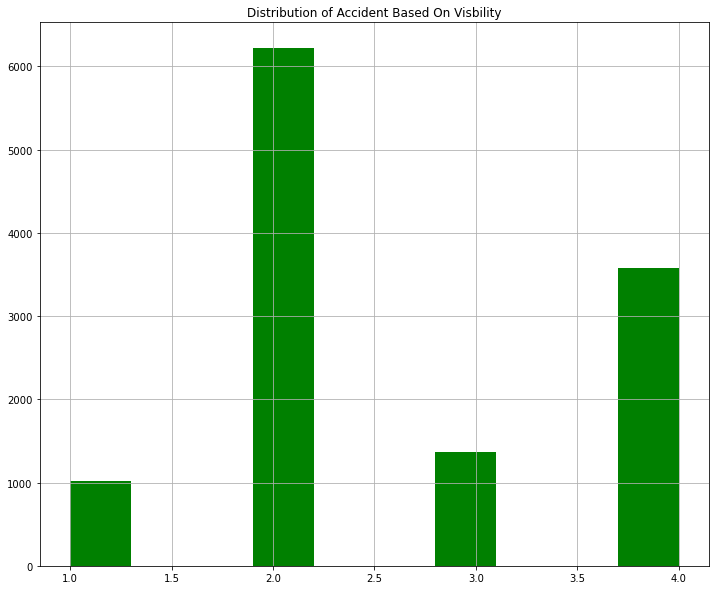

In [10]:
df['visibility'].hist(color='green', figsize=(12, 10))

plt.title('Distribution of Accident Based On Visbility')
plt.show()

----
## Takeaway

Majority of accident happen the day followed by night...not many at dawn or dusk

In [11]:
df.weather = df.weather.astype(int)

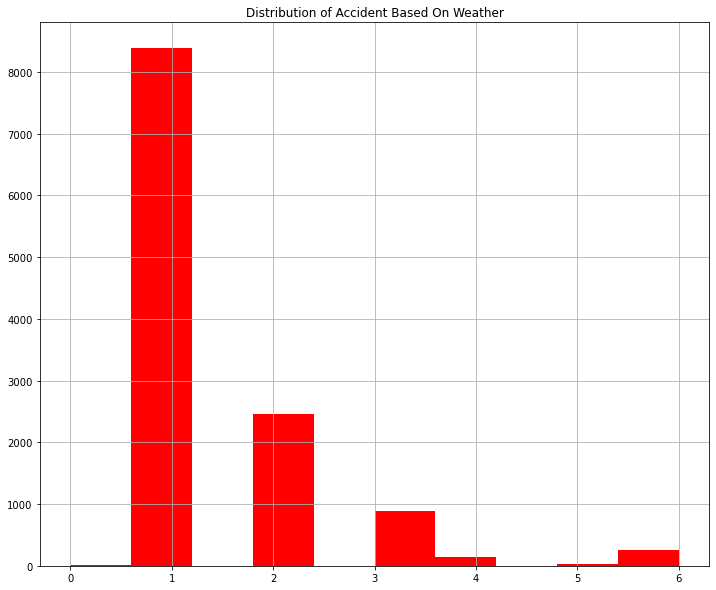

In [12]:
df['weather'].hist(color='red', figsize=(12, 10))

plt.title('Distribution of Accident Based On Weather')
plt.show()

-----

## Takeaway

- Clear weather followed by cloudy skies are when the majority of accidents take place

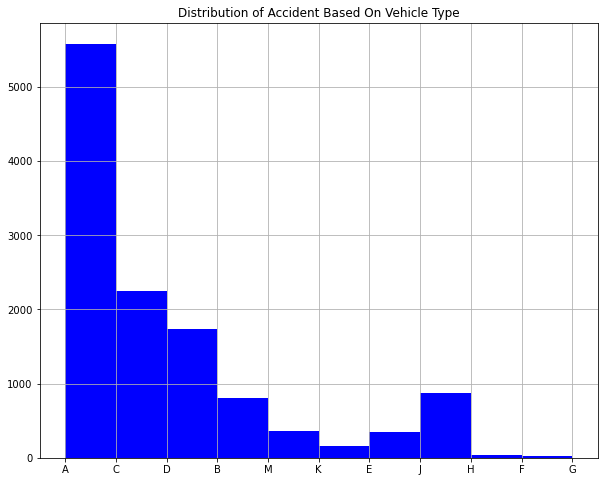

In [13]:
df['vehicle_type'].hist(color='blue', figsize=(10,8))

plt.title('Distribution of Accident Based On Vehicle Type')
plt.show()

In [14]:
df.vehicle_type.value_counts()

A    5585
C    2248
D    1731
J     878
B     804
M     366
E     352
K     156
H      39
F      17
G       5
Name: vehicle_type, dtype: int64


-----
## Takeway
 
 - most accidents are involved with auto(cars) followed by tractor trailers, then pick up trucks. School buses were at the very bottom which was good to see although there were still 5 instances. 

-----------

## OUTLIERS

-------

<AxesSubplot:xlabel='front_engines'>

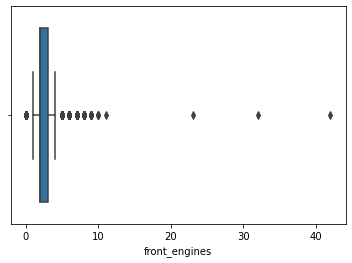

In [15]:
sns.boxplot(data = df, x = 'front_engines')

 - Have some crazy outliers with 3 accidents having over 20 engines

<AxesSubplot:xlabel='railcar_quantity'>

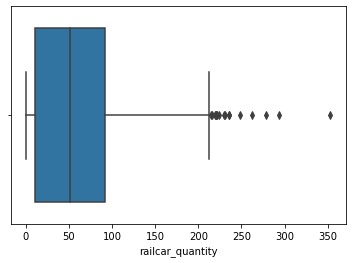

In [16]:
sns.boxplot(data=df, x = 'railcar_quantity')

- majority of railcar quanity is between 0-100 cars but there are some outliers above 200 with one coming in at a whopping 350 cars

<AxesSubplot:xlabel='train_speed'>

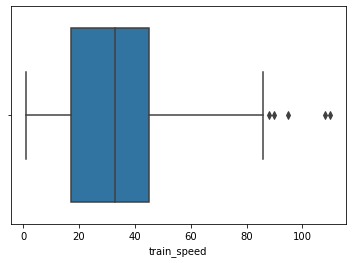

In [17]:
sns.boxplot(data = df, x = 'train_speed')

- train speed outliers above 80 mph, with 2 over 100 mph

<AxesSubplot:xlabel='temp'>

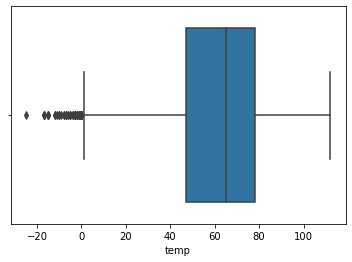

In [18]:
sns.boxplot(data = df, x = 'temp')

- outliers exist for accidents where temp was below 0 degrees with 1 occuring where temp was greater than -20

In [19]:
df.position.value_counts()

3    5578
2    2202
3    1659
1    1589
2     710
1     430
5       6
5       3
4       3
4       1
Name: position, dtype: int64

## Takeaways

- a majority of people involved in accidents were either moving across the crossing when hit or were stopped. A small amount (4 & 5) were either blocked or trapped inside the crossing 

In [20]:
df.road_condtions.value_counts()

A    10133
B     1268
C      430
E      232
D      113
F        5
Name: road_condtions, dtype: int64

## Takeaways

- conditions were dry(A) for a majority of the incidents followed by wet (B) and then snow/slush(C)

In [21]:
df.view_obstruction.value_counts()

8    11794
5       72
3       70
1       69
7       51
6       50
2       46
4       29
Name: view_obstruction, dtype: int64

## Takeaways
- Majority of accidents had zero obstruction while vegetation was next with less than 80 incidents. 

In [22]:
df.motorist_action.value_counts()

3    3768
4    2996
1    1508
5    1485
2     600
3     428
7     388
4     308
5     199
1     195
8     114
2      93
7      58
6      23
8      15
0       2
6       1
Name: motorist_action, dtype: int64

## Takeaways

- Most motorists did not stop for the train (#3) and were hit or they stopped in the crossing(#4) and were hit. After that, people went around gates (#3). Lower on the list were people who went thru the gates(#7) and then those who attempted or committed suicide (#8)

In [23]:
cat_var = ['railroad_company', 'station', 'weather', 'train_type', 'track_type']

---------------------------

## Train Data/Bi-Variate/Multi-Variate Exploration

---------------------

In [24]:
train, validate, test = train_validate_test_split(df, 'railroad_company', seed=123)

In [25]:
train.shape, validate.shape, test.shape

((6820, 51), (2924, 51), (2437, 51))

In [26]:
train.groupby('railroad_company').railcar_quantity.median()

railroad_company
ATK      7
BNSF    69
CSX     49
KCS     61
NS      40
UP      72
Name: railcar_quantity, dtype: int64

## Takeaway

- UP has largest median railcar length followed by BNSF. Amtrack is smallest at 7 but this is because they are strictly passenger 

In [27]:
train.groupby('railroad_company').train_speed.median()

railroad_company
ATK     65.0
BNSF    35.0
CSX     28.5
KCS     35.0
NS      28.0
UP      35.0
Name: train_speed, dtype: float64

## Takeaway

- Median speed across the cargo carriers was no greater than 35 mph and no less than 28 mph. Amtrak was fastest with a median of 65 mph

<AxesSubplot:xlabel='weather', ylabel='Count'>

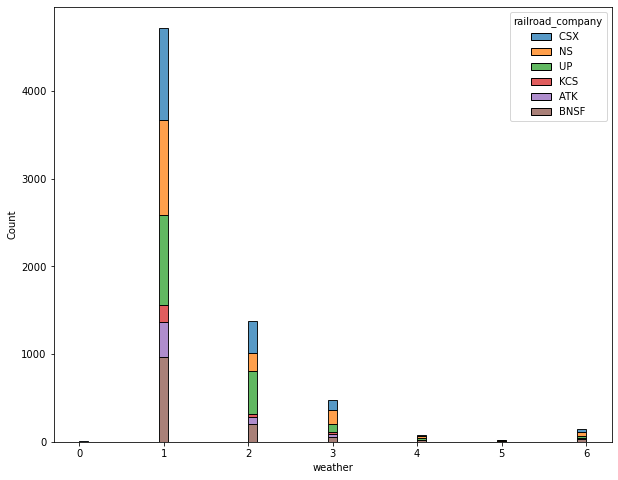

In [28]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x="weather", hue = "railroad_company", multiple="stack")

In [29]:
train.groupby('railroad_company').weather.value_counts()

railroad_company  weather
ATK               1           403
                  2            82
                  3            35
                  6             9
                  4             5
                  5             1
BNSF              1           964
                  2           201
                  3            53
                  6            30
                  4            19
                  5             6
CSX               1          1048
                  2           364
                  3           110
                  6            38
                  4            12
                  0             6
                  5             4
KCS               1           193
                  2            34
                  3            23
                  4             2
                  5             1
NS                1          1084
                  2           204
                  3           166
                  6            47
                  4   

## Takeaways

- KCS had no reported hwy rail accidents in snow (#6) or sleet (#5) condtions
- BNSF had the third higest total (practically a tie with 2nd (CSX) of snow accidents even though they are 4 out of 6 in total accidents)

In [30]:
train.groupby(['railroad_company', 'weather']).vehicle_damage.max()

railroad_company  weather
ATK               1          150000.0
                  2           60000.0
                  3           15117.0
                  4           15000.0
                  5            5000.0
                  6           10000.0
BNSF              1          140000.0
                  2           25000.0
                  3           10000.0
                  4            5000.0
                  5            5000.0
                  6            5000.0
CSX               0           19100.0
                  1          500000.0
                  2          276000.0
                  3           27500.0
                  4           13800.0
                  5           27500.0
                  6           20500.0
KCS               1           75000.0
                  2           50000.0
                  3           20000.0
                  4            4500.0
                  5            6000.0
NS                1          600000.0
                  2     

## Takeaways

- UP had the highest max property damage in Fog with $100,000 while CSX was the winner with a max in the cloudy department. 

In [31]:
train.groupby(['railroad_company', 'season']).vehicle_damage.median()

railroad_company  season
ATK               Fall      7000.0
                  Spring    5000.0
                  Summer    5000.0
                  Winter    5000.0
BNSF              Fall      2000.0
                  Spring    2000.0
                  Summer    2000.0
                  Winter    2000.0
CSX               Fall      6500.0
                  Spring    6500.0
                  Summer    6500.0
                  Winter    6500.0
KCS               Fall      5000.0
                  Spring    5000.0
                  Summer    5250.0
                  Winter    6500.0
NS                Fall      3000.0
                  Spring    2500.0
                  Summer    3000.0
                  Winter    3000.0
UP                Fall      5000.0
                  Spring    5000.0
                  Summer    5000.0
                  Winter    5000.0
Name: vehicle_damage, dtype: float64

## Takeaways

- Median damages seems to be fairly similar on a median basis when spread through each company basaed on the seasons

In [32]:
train.groupby(['railroad_company', 'season']).vehicle_damage.max()

railroad_company  season
ATK               Fall      100000.0
                  Spring    150000.0
                  Summer    100000.0
                  Winter     90000.0
BNSF              Fall      140000.0
                  Spring     20000.0
                  Summer    100000.0
                  Winter     25000.0
CSX               Fall      100000.0
                  Spring    500000.0
                  Summer    276000.0
                  Winter    500000.0
KCS               Fall       40000.0
                  Spring     50000.0
                  Summer     75000.0
                  Winter     50000.0
NS                Fall      400000.0
                  Spring    100000.0
                  Summer    600000.0
                  Winter    100000.0
UP                Fall      175000.0
                  Spring    150000.0
                  Summer    665000.0
                  Winter    200000.0
Name: vehicle_damage, dtype: float64

## Takeaways

- UP saw its biggest property damage in summer as did NS. 
- CSX had a tie for Winter & Spring as its most expensive damage incidents
- KCS saw an uptick in Summer

<AxesSubplot:xlabel='railroad_company,season'>

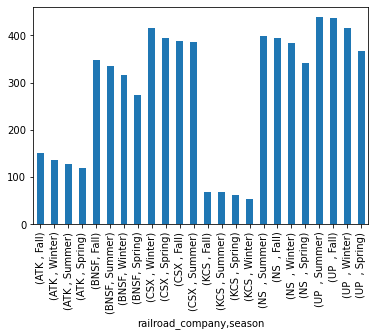

In [33]:
train.groupby('railroad_company').season.value_counts().plot(kind='bar')

In [34]:
train.groupby('railroad_company').vehicle_damage.sum()

railroad_company
ATK      5483435.0
BNSF     3488975.0
CSX     13688313.0
KCS      2567596.0
NS      11115059.0
UP      17808328.0
Name: vehicle_damage, dtype: float64

## Takeaways

- Amtrak, a passenger carrier, had a higher vehicle property damage than BNSF and KCS
- UP leads the pack followed by CSX and NS

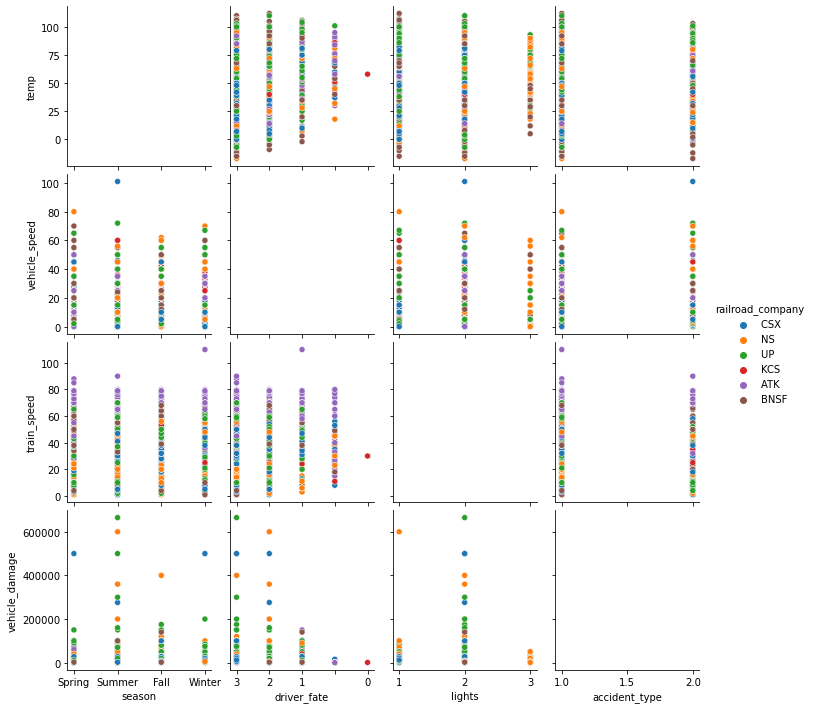

In [35]:
sns.pairplot(data = train, hue = 'railroad_company', 
             x_vars = ["season", "driver_fate", "lights", "accident_type"],
             y_vars = ["temp","vehicle_speed", "train_speed", "vehicle_damage"])

## Takeaways

- Crossings with no lights seem to have a higher frequency of incidents
- Summer is when a larger majority of incidents resulting in damages take place
- The temperature is almost always above 0 when fatal accidents occur

In [36]:
train.groupby('railroad_company').lights.value_counts()

railroad_company  lights
ATK               2         354
                  1         117
                  2          48
                  1           9
                  3           7
BNSF              2         823
                  1         289
                  2          98
                  1          32
                  3          28
                  3           3
CSX               2         872
                  1         516
                  2         112
                  1          81
                  3           1
KCS               2         214
                  2          28
                  1          11
NS                2         912
                  1         328
                  2         120
                  3         103
                  1          45
                  3          12
UP                2         977
                  1         457
                  2         129
                  1          51
                  3          39
               

plt.figure(figsize=(16,8))
sns.swarmplot(x="railroad_company", y="vehicle_damage", data=train, hue="lights", palette="Set2")
plt.legend()
plt.title('Railroad & Vehicle Property Damage Comparison')

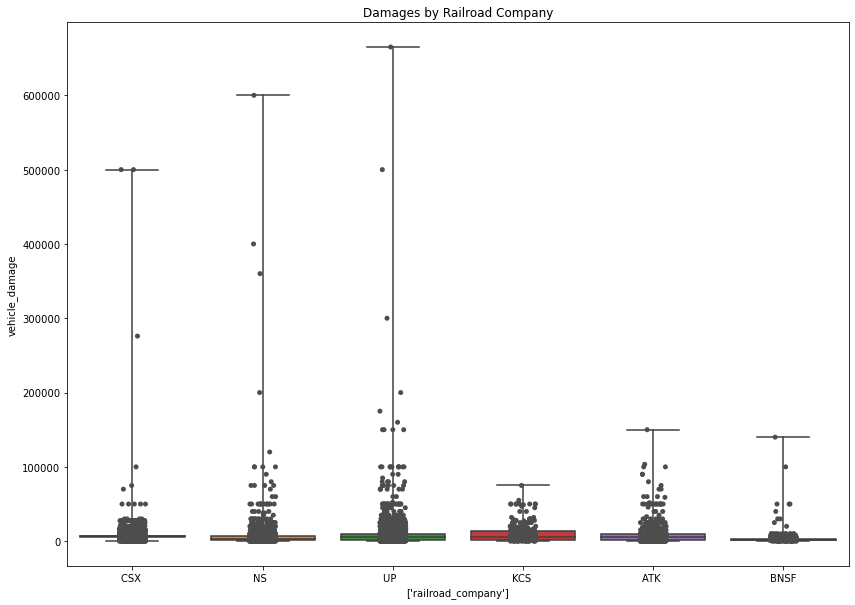

In [37]:

plt.figure(figsize=(14,10))



ax = sns.boxplot(x="railroad_company", y="vehicle_damage", data=train,whis=np.inf )
ax = sns.stripplot(x="railroad_company", y="vehicle_damage", data=train, color=".3")
ax.set_xlabel(['railroad_company'])
plt.title('Damages by Railroad Company')


plt.show()

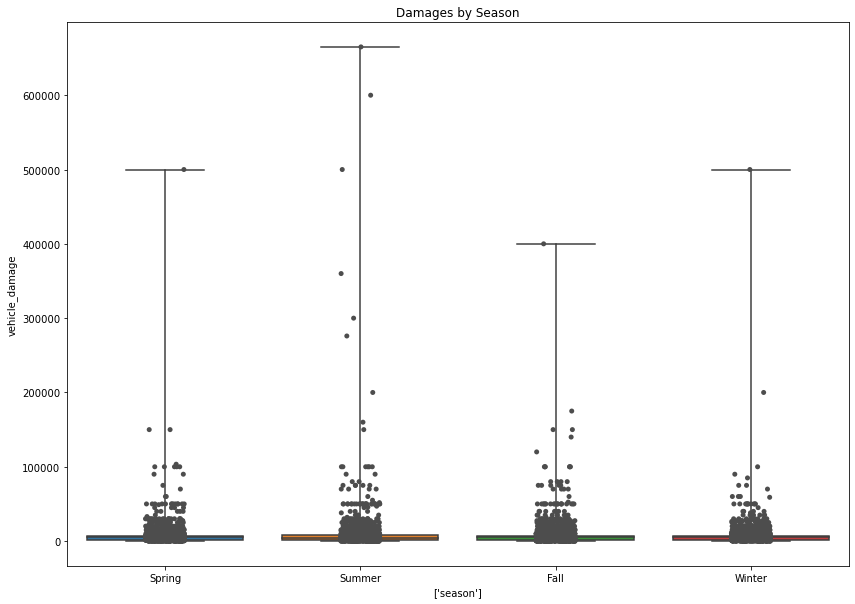

In [38]:

plt.figure(figsize=(14,10))



ax = sns.boxplot(x="season", y="vehicle_damage", data=train,whis=np.inf )
ax = sns.stripplot(x="season", y="vehicle_damage", data=train, color=".3")
ax.set_xlabel(['season'])
plt.title('Damages by Season')


plt.show()

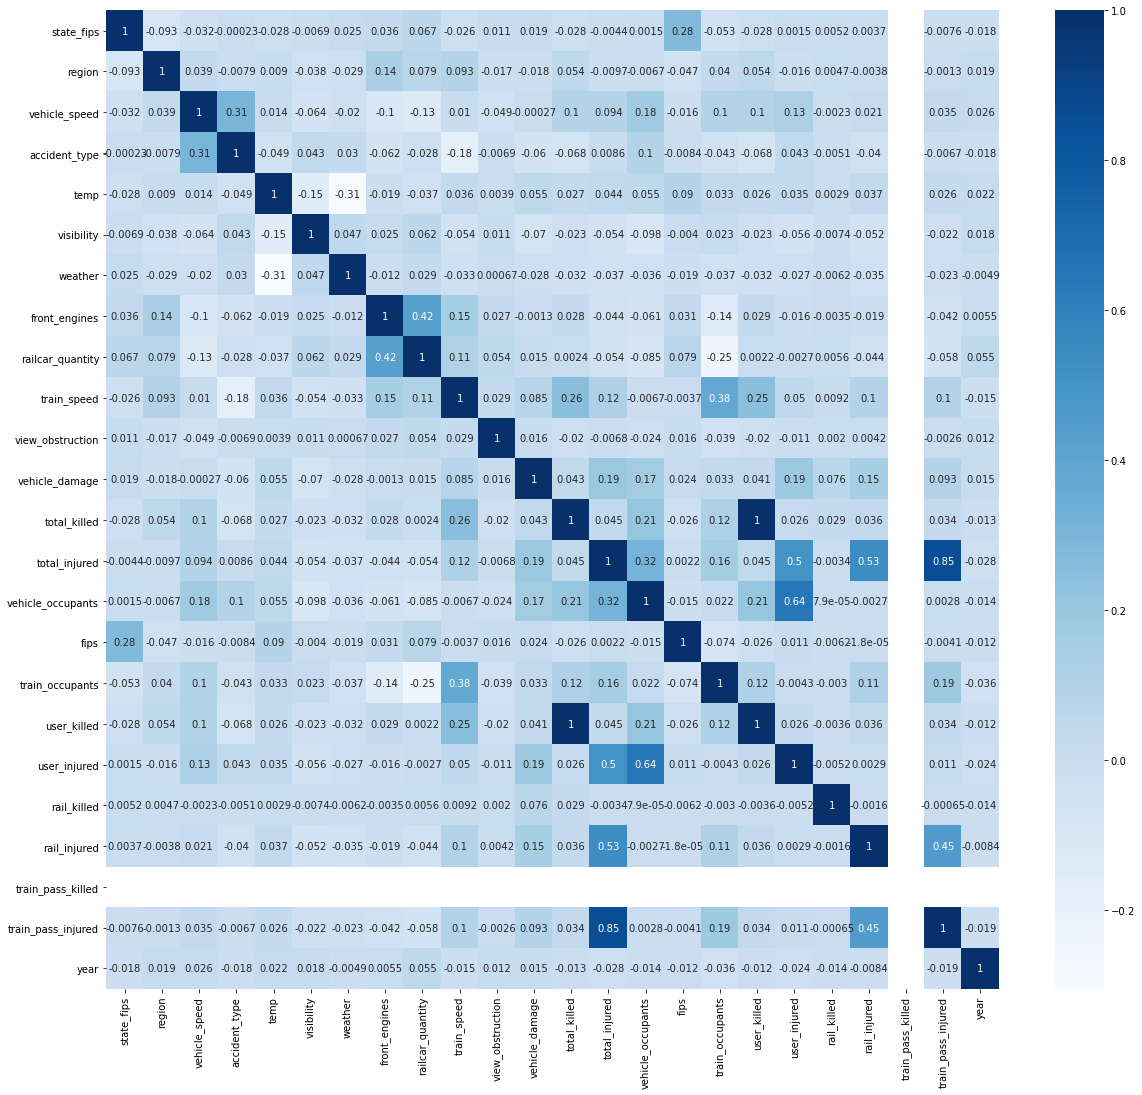

In [46]:

plt.figure(figsize=(20,18))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.show()

In [39]:
df['year'] = df['date'].dt.year

train.groupby('ra

df.year = df.year.astype(object)